In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random

# =================================================================
# 1Îã®Í≥Ñ: ÌååÏùº Î°úÎìú Î∞è Í∏∞Î≥∏ Ï†ÑÏ≤òÎ¶¨
# =================================================================
WINDOW_SIZE = 3
# FILE_PATH = './dataSet/factory_all_data.csv'
FILE_PATH = './dataSet/factory_20pct_data.csv'

try:
    df = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    print(f"Ïò§Î•ò: '{FILE_PATH}' ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")
    exit()

df['event_time'] = pd.to_datetime(df['event_time'])

# =================================================================
# 2Îã®Í≥Ñ: Îã®Ïñ¥Ïû• ÏÉùÏÑ±
# =================================================================
unique_event_types = df['event_type'].unique().tolist()
event_type_vocab = ['<PAD>', '<UNK>'] + unique_event_types
event_type_to_idx = {etype: i for i, etype in enumerate(event_type_vocab)}
print("--- ÏÉùÏÑ±Îêú Îã®Ïñ¥Ïû• (ÏÇ¨Ï†Ñ) ---")
print(f"Ï¥ù Îã®Ïñ¥ Ïàò: {len(event_type_to_idx)}")
# print(event_type_to_idx) # Îã®Ïñ¥Ïû•Ïù¥ Í∏∏Î©¥ Ï£ºÏÑù Ï≤òÎ¶¨
print("-" * 35)

# =================================================================
# 3Îã®Í≥Ñ: ÌÖçÏä§Ìä∏ ÏãúÌÄÄÏä§ Î∞è EPC Íº¨Î¶¨Ìëú ÏÉùÏÑ±
# =================================================================
sequence_set_text = []
epc_for_each_sequence = []

grouped = df.groupby('epc_code')
for epc, group_df in grouped:
    sorted_group = group_df.sort_values(by='event_time').reset_index(drop=True)
    processed_group = sorted_group[['location_id', 'event_type', 'event_time']]
    if len(processed_group) < WINDOW_SIZE:
        pad_len = WINDOW_SIZE - len(processed_group)
        padding_df = pd.DataFrame({'location_id': [0] * pad_len, 'event_type': ['<PAD>'] * pad_len, 'event_time': pd.to_datetime([pd.NaT] * pad_len)})
        padded_sequence = pd.concat([padding_df, processed_group], ignore_index=True)
        sequence_set_text.append(padded_sequence)
        epc_for_each_sequence.append(epc)
    else:
        num_windows = len(processed_group) - WINDOW_SIZE + 1
        for i in range(num_windows):
            window = processed_group.iloc[i : i + WINDOW_SIZE].reset_index(drop=True)
            sequence_set_text.append(window)
            epc_for_each_sequence.append(epc)

print(f"‚úÖ 3Îã®Í≥Ñ: ÌÖçÏä§Ìä∏ ÏãúÌÄÄÏä§ ÏÉùÏÑ± ÏôÑÎ£å. Ï¥ù {len(sequence_set_text)}Í∞ú")

# =================================================================
# 4Îã®Í≥Ñ: ÌÖçÏä§Ìä∏ ÏãúÌÄÄÏä§Î•º Ïà´Ïûê ÏãúÌÄÄÏä§Î°ú Î≥ÄÌôò (Î™®Îç∏ ÏûÖÎ†•Ïö©)
# =================================================================
sequence_set_processed = []
unk_idx = event_type_to_idx['<UNK>']

for seq_df in sequence_set_text:
    df_copy = seq_df.copy()
    mapped_series = df_copy['event_type'].map(event_type_to_idx)
    df_copy['event_type'] = mapped_series.fillna(unk_idx).astype(int)
    
    def time_to_tan(t):
        if pd.isna(t): return 0.0
        seconds_in_day = 86400
        seconds_from_midnight = t.hour * 3600 + t.minute * 60 + t.second
        normalized_time = seconds_from_midnight / seconds_in_day
        return np.tan((normalized_time - 0.5) * np.pi)

    df_copy['time_tan'] = df_copy['event_time'].apply(time_to_tan)
    final_df = df_copy[['location_id', 'event_type', 'time_tan']]
    sequence_set_processed.append(final_df)
    
print(f"‚úÖ 4Îã®Í≥Ñ: Ïà´Ïûê ÏãúÌÄÄÏä§ Î≥ÄÌôò ÏôÑÎ£å. Ï¥ù {len(sequence_set_processed)}Í∞ú")

# =================================================================
# 5Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨ (Train / Test Split)
# =================================================================
indices = np.arange(len(sequence_set_processed))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_sequences_processed = [sequence_set_processed[i] for i in train_indices]
test_sequences_text = [sequence_set_text[i] for i in test_indices]
test_epcs = [epc_for_each_sequence[i] for i in test_indices]

print(f"\n‚úÖ 5Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨ ÏôÑÎ£å")
print(f"ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ Ïàò: {len(train_sequences_processed)}")
print(f"ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ïàò: {len(test_sequences_text)}")

# =================================================================
# 6Îã®Í≥Ñ: ÎπÑÏ†ïÏÉÅ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± (ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏÖã Í∏∞Î∞ò)
# =================================================================
# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïùò Ï†àÎ∞òÏùÑ ÎπÑÏ†ïÏÉÅ Îç∞Ïù¥ÌÑ∞Î°ú ÎßåÎì≠ÎãàÎã§.
n_anomalies_to_create = len(test_sequences_text) // 2

generated_anomalies_text = []
all_event_types = [event for event in event_type_to_idx.keys() if event not in ['<PAD>', '<UNK>']]

for i in range(n_anomalies_to_create):
    normal_sequence_df = test_sequences_text[i].copy()
    real_data_mask = normal_sequence_df['event_type'] != '<PAD>'
    real_data_indices = normal_sequence_df[real_data_mask].index
    if len(real_data_indices) < 2: continue

    anomaly_type = random.choice(['shuffle', 'replace', 'time'])
    anomaly_df = normal_sequence_df.copy()

    if anomaly_type == 'shuffle':
        shuffled_events = anomaly_df.loc[real_data_indices, 'event_type'].sample(frac=1).values
        anomaly_df.loc[real_data_indices, 'event_type'] = shuffled_events
    elif anomaly_type == 'replace':
        replace_idx = random.choice(real_data_indices)
        original_event = anomaly_df.loc[replace_idx, 'event_type']
        possible_replacements = [e for e in all_event_types if e != original_event]
        if not possible_replacements: continue
        new_event = random.choice(possible_replacements)
        anomaly_df.loc[replace_idx, 'event_type'] = new_event
    elif anomaly_type == 'time':
        last_event_idx = real_data_indices[-1]
        anomaly_df.loc[last_event_idx, 'event_time'] += pd.to_timedelta('30D')

    generated_anomalies_text.append(anomaly_df)

print(f"\n‚úÖ 6Îã®Í≥Ñ: ÎπÑÏ†ïÏÉÅ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± ÏôÑÎ£å")
print(f"Ï¥ù {len(generated_anomalies_text)}Í∞úÏùò ÎπÑÏ†ïÏÉÅ ÏãúÌÄÄÏä§Í∞Ä ÏÉùÏÑ±ÎêòÏóàÏäµÎãàÎã§.")

# =================================================================
# 7Îã®Í≥Ñ: ÏµúÏ¢Ö ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨ÏÑ± (X_train, y_train)
# =================================================================
# "Ï†ïÏÉÅ ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ (train_sequences_processed)"Îßå ÏÇ¨Ïö©ÌïòÏó¨ NumPy Î∞∞Ïó¥Î°ú Î≥ÄÌôòÌï©ÎãàÎã§.
X_location_list = [seq['location_id'].values for seq in train_sequences_processed]
X_event_type_list = [seq['event_type'].values for seq in train_sequences_processed]
X_time_tan_list = [seq['time_tan'].values for seq in train_sequences_processed]

X_location_np = np.array(X_location_list)
X_event_type_np = np.array(X_event_type_list)
X_time_tan_np = np.array(X_time_tan_list)[..., np.newaxis]

X_train = [X_location_np, X_event_type_np, X_time_tan_np]
y_train = [X_location_np, X_event_type_np, X_time_tan_np]

print(f"\n‚úÖ ÏµúÏ¢Ö Îã®Í≥Ñ: ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨ÏÑ± ÏôÑÎ£å")
print("Ïù¥Ï†ú Î™®Îç∏ÏùÑ ÌïôÏäµÏãúÌÇ¨ Ï§ÄÎπÑÍ∞Ä ÎêòÏóàÏäµÎãàÎã§.")
print(f"Location Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú: {X_location_np.shape}")
print(f"Event Type Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú: {X_event_type_np.shape}")
print(f"Time Tan Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú: {X_time_tan_np.shape}")

--- ÏÉùÏÑ±Îêú Îã®Ïñ¥Ïû• (ÏÇ¨Ï†Ñ) ---
Ï¥ù Îã®Ïñ¥ Ïàò: 12
-----------------------------------
‚úÖ 3Îã®Í≥Ñ: ÌÖçÏä§Ìä∏ ÏãúÌÄÄÏä§ ÏÉùÏÑ± ÏôÑÎ£å. Ï¥ù 118426Í∞ú
‚úÖ 4Îã®Í≥Ñ: Ïà´Ïûê ÏãúÌÄÄÏä§ Î≥ÄÌôò ÏôÑÎ£å. Ï¥ù 118426Í∞ú

‚úÖ 5Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨ ÏôÑÎ£å
ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ Ïàò: 94740
ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ïàò: 23686

‚úÖ 6Îã®Í≥Ñ: ÎπÑÏ†ïÏÉÅ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± ÏôÑÎ£å
Ï¥ù 11843Í∞úÏùò ÎπÑÏ†ïÏÉÅ ÏãúÌÄÄÏä§Í∞Ä ÏÉùÏÑ±ÎêòÏóàÏäµÎãàÎã§.

‚úÖ ÏµúÏ¢Ö Îã®Í≥Ñ: ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨ÏÑ± ÏôÑÎ£å
Ïù¥Ï†ú Î™®Îç∏ÏùÑ ÌïôÏäµÏãúÌÇ¨ Ï§ÄÎπÑÍ∞Ä ÎêòÏóàÏäµÎãàÎã§.
Location Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú: (94740, 3)
Event Type Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú: (94740, 3)
Time Tan Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú: (94740, 3, 1)


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, RepeatVector, TimeDistributed

# Î™®Îç∏ ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞
# LOCATION_VOCAB_SIZE = df['location_id'].nunique() + 1
LOCATION_VOCAB_SIZE = df['location_id'].max() + 1
EVENT_TYPE_VOCAB_SIZE = len(event_type_to_idx)
EMBEDDING_DIM = 16
LATENT_DIM = 16

# 1. ÏûÖÎ†•Ï∏µ
input_location = Input(shape=(WINDOW_SIZE,), name='input_location')
input_event_type = Input(shape=(WINDOW_SIZE,), name='input_event_type')
input_time_tan = Input(shape=(WINDOW_SIZE, 1), name='input_time_tan')

# 2. ÏûÑÎ≤†Îî© Î∞è Í≤∞Ìï©
embedding_location = Embedding(input_dim=LOCATION_VOCAB_SIZE, output_dim=EMBEDDING_DIM)(input_location)
embedding_event_type = Embedding(input_dim=EVENT_TYPE_VOCAB_SIZE, output_dim=EMBEDDING_DIM)(input_event_type)
concatenated_inputs = Concatenate()([embedding_location, embedding_event_type, input_time_tan])

# 3. Ïù∏ÏΩîÎçî
encoder_lstm = LSTM(LATENT_DIM, activation='relu')(concatenated_inputs)

# 4. ÎîîÏΩîÎçî
repeat_vector = RepeatVector(WINDOW_SIZE)(encoder_lstm)
decoder_lstm = LSTM(EMBEDDING_DIM * 2 + 1, activation='relu', return_sequences=True)(repeat_vector)

# 5. Ï∂úÎ†•Ï∏µ
output_location = TimeDistributed(Dense(LOCATION_VOCAB_SIZE, activation='softmax'), name='output_location')(decoder_lstm)
output_event_type = TimeDistributed(Dense(EVENT_TYPE_VOCAB_SIZE, activation='softmax'), name='output_event_type')(decoder_lstm)
output_time_tan = TimeDistributed(Dense(1), name='output_time_tan')(decoder_lstm)

# 6. Î™®Îç∏ ÏÉùÏÑ±
autoencoder = Model(inputs=[input_location, input_event_type, input_time_tan],
                    outputs=[output_location, output_event_type, output_time_tan])

print("\n‚úÖ 3Îã®Í≥Ñ: Ïò§ÌÜ†Ïù∏ÏΩîÎçî Î™®Îç∏ Íµ¨Ï∂ï ÏôÑÎ£å")
autoencoder.summary()


‚úÖ 3Îã®Í≥Ñ: Ïò§ÌÜ†Ïù∏ÏΩîÎçî Î™®Îç∏ Íµ¨Ï∂ï ÏôÑÎ£å


Model: "functional"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_location      ‚îÇ (None, 3)         ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ input_event_type    ‚îÇ (None, 3)         ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ embedding           ‚îÇ (None, 3, 16)     ‚îÇ      2,544 ‚îÇ input_location[0‚Ä¶ ‚îÇ
‚îÇ (Embedding)         ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ embedding_1         ‚îÇ (None, 3, 16)     ‚îÇ        192 ‚îÇ input_event_type‚Ä¶ ‚îÇ
‚îÇ (Embedding)         ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ input_time_tan      ‚îÇ (None, 3, 1)      ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ concatenate         ‚îÇ (None, 3, 33)     ‚îÇ          0 ‚îÇ embedding[0][0],  ‚îÇ
‚îÇ (Concatenate)       ‚îÇ                   ‚îÇ            ‚îÇ embedding_1[0][0‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ                   ‚îÇ            ‚îÇ input_time_tan[0‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm (LSTM)         ‚îÇ (None, 16)        ‚îÇ      3,200 ‚îÇ concatenate[0][0] ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ repeat_vector       ‚îÇ (None, 3, 16)     ‚îÇ          0 ‚îÇ lstm[0][0]        ‚îÇ
‚îÇ (RepeatVector)      ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_1 (LSTM)       ‚îÇ (None, 3, 33)     ‚îÇ      6,600 ‚îÇ repeat_vector[0]‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚î

 Total params: 18,384 (71.81 KB)

 Trainable params: 18,384 (71.81 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
from tensorflow.keras.callbacks import EarlyStopping

# Í∞Å Ï∂úÎ†•Ïóê ÎßûÎäî ÏÜêÏã§ Ìï®Ïàò ÏßÄÏ†ï
losses = {
    'output_location': 'sparse_categorical_crossentropy',
    'output_event_type': 'sparse_categorical_crossentropy',
    'output_time_tan': 'mean_squared_error'
}

autoencoder.compile(optimizer='adam', loss=losses)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\n‚úÖ 4Îã®Í≥Ñ: Î™®Îç∏ ÌïôÏäµ ÏãúÏûë (Ï°∞Í∏∞ Ï¢ÖÎ£å Ï†ÅÏö©)")
history = autoencoder.fit(
    X_train,
    y_train,
    epochs=200,  # ÏµúÎåÄ ÏóêÌè¨ÌÅ¨Îäî ÎÑâÎÑâÌïòÍ≤å ÏÑ§Ï†ï, EarlyStoppingÏù¥ ÏïåÏïÑÏÑú ÏµúÏ†ÅÏùò ÏãúÏ†êÏóê Î©àÏ∂∞Ï§å
    batch_size=64,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stopping]  # <<< [ÌïµÏã¨] ÏΩúÎ∞± Î¶¨Ïä§Ìä∏Î•º Ï†ÑÎã¨
)

print("\nüéâ Î™®Îç∏ ÌïôÏäµ ÏôÑÎ£å!")


‚úÖ 4Îã®Í≥Ñ: Î™®Îç∏ ÌïôÏäµ ÏãúÏûë (Ï°∞Í∏∞ Ï¢ÖÎ£å Ï†ÅÏö©)
Epoch 1/200
1333/1333 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 4ms/step - loss: 64.1618 - output_event_type_loss: 1.9164 - output_location_loss: 3.3666 - output_time_tan_loss: 58.8789 - val_loss: 4.8570 - val_output_event_type_loss: 0.4042 - val_output_location_loss: 1.3296 - val_output_time_tan_loss: 3.0953
Epoch 2/200
1333/1333 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 4ms/step - loss: 3.4859 - output_event_type_loss: 0.3424 - output_location_loss: 1.1988 - output_time_tan_loss: 1.9447 - val_loss: 5.8838 - val_output_event_type_loss: 0.2111 - val_output_location_loss: 0.8471 - val_output_time_tan_loss: 4.7882
Epoch 3/200
1333/1333 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 4ms/step - loss: 3.0161 - output_event_type_loss: 0.2138 - output_location_loss: 0.8227 - output_time_tan_loss: 1.9796 - val_loss: 1.5583 - val_output_event_type_loss: 0.1670 - val_output_loca


‚úÖ 8Îã®Í≥Ñ: Î™®Îç∏ ÌèâÍ∞Ä ÏãúÏûë
ÏµúÏ¢Ö ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Íµ¨ÏÑ± ÏôÑÎ£å. (Ï†ïÏÉÅ: 11843Í∞ú, ÎπÑÏ†ïÏÉÅ: 11843Í∞ú)
741/741 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2ms/step

Î™®Îç∏ AUC Ï†êÏàò: 0.7797
ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í: 2.0615


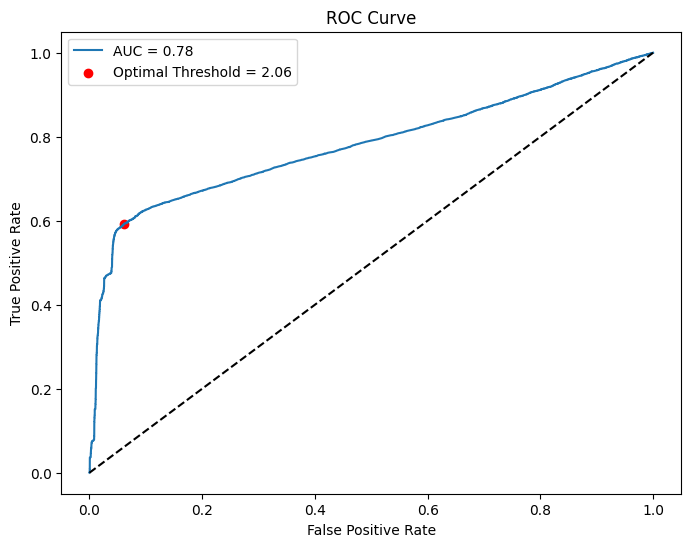


--- Classification Report ---
              precision    recall  f1-score   support

  Normal (0)       0.70      0.94      0.80     11843
 Anomaly (1)       0.91      0.59      0.72     11843

    accuracy                           0.77     23686
   macro avg       0.80      0.77      0.76     23686
weighted avg       0.80      0.77      0.76     23686



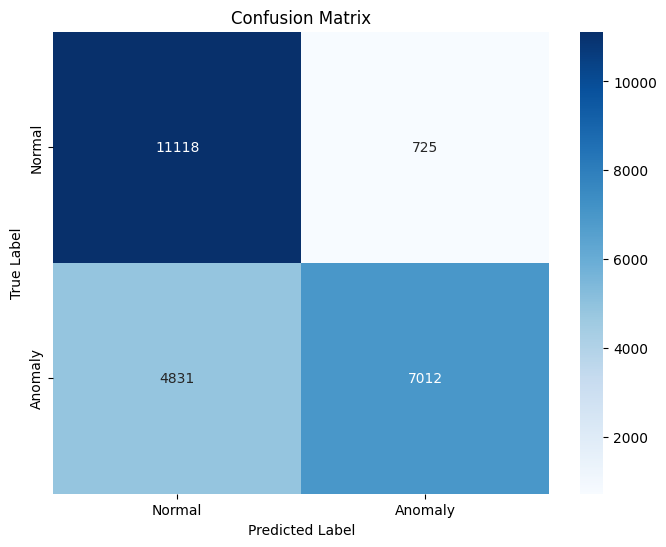


--- Î™®Îç∏Ïù¥ 'ÎπÑÏ†ïÏÉÅ'ÏúºÎ°ú ÌÉêÏßÄÌïú Ïù¥Îèô Î™©Î°ù (ÏÉÅÏúÑ 10Í∞ú) ---
                                           epc_code  from_location  \
609   001.8805843.3812382.010003.20250701.000003523             68   
946   001.8805843.3812382.010003.20250701.000003523             68   
303   001.8809437.1203199.010002.20250701.000000411             71   
4847  001.8809437.1203199.100002.20250701.000001348             17   
6474  001.8809437.1203199.100002.20250701.000001428              9   
318   001.8805843.3812382.100003.20250701.000002136             35   
44    001.8805843.3812382.100003.20250701.000002169             35   
4624  001.8805843.3812382.100003.20250701.000002167             35   
3499  001.8805843.3812382.100003.20250701.000002146             35   
5362  001.8809437.1203199.100002.20250701.000001267             17   

      to_location  reconstruction_error      is_correct  
609            68          17026.210938  False Positive  
946            68            124.4959

In [4]:
# =================================================================
# 8Îã®Í≥Ñ: Î™®Îç∏ ÌèâÍ∞Ä Î∞è Ïù¥ÏÉÅ ÌÉêÏßÄ Í≤∞Í≥º Î∂ÑÏÑù
# =================================================================
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import datetime
import subprocess

print("\n‚úÖ 8Îã®Í≥Ñ: Î™®Îç∏ ÌèâÍ∞Ä ÏãúÏûë")

# --- 1. ÏµúÏ¢Ö ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨ÏÑ± (Ï†ïÏÉÅ + ÎπÑÏ†ïÏÉÅ) ---
# ÌÖåÏä§Ìä∏ÏÖãÏóêÏÑú ÎπÑÏ†ïÏÉÅ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±Ïóê ÏÇ¨Ïö©ÎêòÏßÄ ÏïäÏùÄ ÎÇòÎ®∏ÏßÄ 'Ï†ïÏÉÅ' Îç∞Ïù¥ÌÑ∞
n_anomalies_created = len(generated_anomalies_text)
normal_test_sequences_text = test_sequences_text[n_anomalies_created:]

# ÏµúÏ¢Ö ÌÖåÏä§Ìä∏ÏÖã = (Ï†ïÏÉÅ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ + ÏÉùÏÑ±Îêú ÎπÑÏ†ïÏÉÅ Îç∞Ïù¥ÌÑ∞)
final_test_sequences_text = normal_test_sequences_text + generated_anomalies_text
# Ï†ïÎãµ Î†àÏù¥Î∏î ÏÉùÏÑ± (Ï†ïÏÉÅ: 0, ÎπÑÏ†ïÏÉÅ: 1)
y_test_labels = [0] * len(normal_test_sequences_text) + [1] * len(generated_anomalies_text)

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÎèÑ Î™®Îç∏ ÏûÖÎ†•Ïóê ÎßûÍ≤å Ïà´Ïûê(processed) ÌòïÌÉúÎ°ú Î≥ÄÌôò
test_sequences_processed = []
for seq_df in final_test_sequences_text:
    df_copy = seq_df.copy()
    mapped_series = df_copy['event_type'].map(event_type_to_idx)
    df_copy['event_type'] = mapped_series.fillna(unk_idx).astype(int)
    
    def time_to_tan(t):
        if pd.isna(t): return 0.0
        seconds_in_day = 86400
        seconds_from_midnight = t.hour * 3600 + t.minute * 60 + t.second
        normalized_time = seconds_from_midnight / seconds_in_day
        return np.tan((normalized_time - 0.5) * np.pi)

    df_copy['time_tan'] = df_copy['event_time'].apply(time_to_tan)
    final_df = df_copy[['location_id', 'event_type', 'time_tan']]
    test_sequences_processed.append(final_df)

# NumPy Î∞∞Ïó¥Î°ú Î≥ÄÌôò
X_test_location = np.array([seq['location_id'].values for seq in test_sequences_processed])
X_test_event_type = np.array([seq['event_type'].values for seq in test_sequences_processed])
X_test_time_tan = np.array([seq['time_tan'].values for seq in test_sequences_processed])[..., np.newaxis]
X_test = [X_test_location, X_test_event_type, X_test_time_tan]

print(f"ÏµúÏ¢Ö ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Íµ¨ÏÑ± ÏôÑÎ£å. (Ï†ïÏÉÅ: {y_test_labels.count(0)}Í∞ú, ÎπÑÏ†ïÏÉÅ: {y_test_labels.count(1)}Í∞ú)")


# --- 2. ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú Ïû¨Íµ¨ÏÑ± Ïò§Î•ò Í≥ÑÏÇ∞ ---
predicted_test = autoencoder.predict(X_test)
predicted_loc, predicted_event, predicted_time = predicted_test

# Keras ÏÜêÏã§ Ìï®ÏàòÎ•º ÏßÅÏ†ë ÏûÑÌè¨Ìä∏ÌïòÏó¨ Ïò§Î•ò Í≥ÑÏÇ∞
loc_errors = np.mean(tf.keras.losses.sparse_categorical_crossentropy(X_test[0], predicted_loc), axis=1)
event_errors = np.mean(tf.keras.losses.sparse_categorical_crossentropy(X_test[1], predicted_event), axis=1)
time_errors = np.mean(tf.keras.losses.mse(X_test[2], predicted_time), axis=1)
total_test_errors = loc_errors + event_errors + time_errors


# --- 3. ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í(Threshold) Ï∞æÍ∏∞ (ROC Ïª§Î∏å ÌôúÏö©) ---
fpr, tpr, thresholds = roc_curve(y_test_labels, total_test_errors)
auc_score = roc_auc_score(y_test_labels, total_test_errors)

# ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í: TPR - FPRÏù¥ ÏµúÎåÄÍ∞Ä ÎêòÎäî ÏßÄÏ†ê (Youden's J statistic)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"\nÎ™®Îç∏ AUC Ï†êÏàò: {auc_score:.4f}")
print(f"ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í: {optimal_threshold:.4f}")

# ROC Ïª§Î∏å ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--') # 50% ÏÑ±Îä•ÏÑ†
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# --- 4. ÏµúÏ¢Ö ÏÑ±Îä• ÌèâÍ∞Ä (Classification Report & Confusion Matrix) ---
final_predictions = (total_test_errors > optimal_threshold).astype(int)

report_dict = classification_report(y_test_labels, final_predictions, target_names=['Normal (0)', 'Anomaly (1)'], output_dict=True)
print("\n--- Classification Report ---")
print(classification_report(y_test_labels, final_predictions, target_names=['Normal (0)', 'Anomaly (1)']))

# Confusion Matrix ÏãúÍ∞ÅÌôî
cm = confusion_matrix(y_test_labels, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# --- 5. Î™®Îç∏Ïù¥ 'ÎπÑÏ†ïÏÉÅ'ÏúºÎ°ú ÌåêÎã®Ìïú Ïù¥Îèô Î∂ÑÏÑù ---
anomaly_indices = np.where(final_predictions == 1)[0]
test_normal_epcs = test_epcs[n_anomalies_created:]
generated_anomaly_epcs = test_epcs[:n_anomalies_created]
final_test_epcs = test_normal_epcs + generated_anomaly_epcs

anomalies_detected = []
for idx in anomaly_indices:
    detected_sequence_df = final_test_sequences_text[idx]
    
    real_data = detected_sequence_df[detected_sequence_df['event_type'] != '<PAD>']
    if len(real_data) < 2: continue

    from_event = real_data.iloc[-2]
    to_event = real_data.iloc[-1]
    
    anomalies_detected.append({
        'epc_code': final_test_epcs[idx],
        'from_location': int(from_event['location_id']),
        'to_location': int(to_event['location_id']),
        'reconstruction_error': total_test_errors[idx],
        'is_correct': 'True Positive' if y_test_labels[idx] == 1 else 'False Positive'
    })

anomaly_df = pd.DataFrame(anomalies_detected).sort_values(by='reconstruction_error', ascending=False)
print("\n--- Î™®Îç∏Ïù¥ 'ÎπÑÏ†ïÏÉÅ'ÏúºÎ°ú ÌÉêÏßÄÌïú Ïù¥Îèô Î™©Î°ù (ÏÉÅÏúÑ 10Í∞ú) ---")
print(anomaly_df.head(10))

# --- Ïã§Ìóò Ï†ïÎ≥¥ ÏàòÏßë ---
# 1. ÏÑ±Îä• ÏßÄÌëú Ï∂îÏ∂ú
anomaly_metrics = report_dict['Anomaly (1)']
recall = anomaly_metrics['recall']
precision = anomaly_metrics['precision']
f1_score = anomaly_metrics['f1-score']

# 2. ÎÇ†Ïßú Î∞è ÏãúÍ∞Ñ Ï†ïÎ≥¥
run_date = datetime.now().strftime('%y/%m/%d')
experiment_id = f"exp-{datetime.now().strftime('%Y%m%d-%H%M%S')}"

# 3. Git Ïª§Î∞ã Ìï¥Ïãú Ï†ïÎ≥¥ (Git Ï†ÄÏû•ÏÜåÍ∞Ä ÏïÑÎãàÎ©¥ 'N/A' Ï≤òÎ¶¨)
try:
    commit_hash = subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).strip().decode('utf-8')
except (subprocess.CalledProcessError, FileNotFoundError):
    commit_hash = "N/A"

# 4. (ÏàòÎèô ÏûÖÎ†•) ÌòÑÏû¨ Ïã§ÌóòÏùò Ï£ºÏöî Î≥ÄÍ≤ΩÏ†ê
# *** Ïù¥ Î∂ÄÎ∂ÑÏùÄ Ïã§ÌóòÌï† ÎïåÎßàÎã§ ÏßÅÏ†ë ÏàòÏ†ïÌï¥Ï£ºÏÑ∏Ïöî! ***
main_change_notes = "Baseline Î™®Îç∏, Ï¥àÍ∏∞ ÌååÎùºÎØ∏ÌÑ∞Î°ú ÏÑ±Îä• Ï∏°Ï†ï"
# ÏòàÏãú: main_change_notes = "EMBEDDING_DIM = 32Î°ú Î≥ÄÍ≤Ω"
# ÏòàÏãú: main_change_notes = "LATENT_DIM = 4Î°ú Î≥ÄÍ≤Ω"


# --- Markdown ÌÖçÏä§Ìä∏ ÏÉùÏÑ± ---
summary_table_row = f"| {experiment_id} | {run_date} | {main_change_notes} | {auc_score:.3f} | {recall:.2f} | {precision:.2f} | {f1_score:.2f} | `{commit_hash}` |"

detailed_summary = f"""
### {experiment_id}: {main_change_notes} ({run_date})
- **Ïª§Î∞ã Ìï¥Ïãú:** `{commit_hash}`
- **Í∞ÄÏÑ§:** (Ïó¨Í∏∞Ïóê Ïù¥ Ïã§ÌóòÏùÑ Ïôú ÌñàÎäîÏßÄ Í∞ÄÏÑ§ÏùÑ ÏûëÏÑ±ÌïòÏÑ∏Ïöî)
- **ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞:**
  - `WINDOW_SIZE`: {WINDOW_SIZE}
  - `EMBEDDING_DIM`: {EMBEDDING_DIM}
  - `LATENT_DIM`: {LATENT_DIM}
  - `BATCH_SIZE`: (ÌïôÏäµ Ïãú ÏÇ¨Ïö©Ìïú batch_size Í∞í)
  - `EPOCHS`: (ÌïôÏäµ Ïãú ÏÇ¨Ïö©Ìïú epochs Í∞í)
- **Í≤∞Í≥º Î∂ÑÏÑù:**
  - AUC: {auc_score:.4f}
  - Anomaly Recall: {recall:.4f} (ÎπÑÏ†ïÏÉÅ Îç∞Ïù¥ÌÑ∞ Ï§ë {recall*100:.1f}%Î•º ÌÉêÏßÄÌï®)
  - Anomaly Precision: {precision:.4f} (ÎπÑÏ†ïÏÉÅÏù¥ÎùºÍ≥† ÏòàÏ∏°Ìïú Í≤É Ï§ë {precision*100:.1f}%Í∞Ä ÏßÑÏßú ÎπÑÏ†ïÏÉÅ)
- **Í≤∞Î°†:** (Ïó¨Í∏∞Ïóê Ïã§Ìóò Í≤∞Í≥ºÏóê ÎåÄÌïú Í≤∞Î°†ÏùÑ ÏûëÏÑ±ÌïòÏÑ∏Ïöî)
"""

# --- ÏµúÏ¢Ö Í≤∞Í≥º Ï∂úÎ†• ---
print("\n" + "="*80)
print("üìã Ïã§Ìóò Í≤∞Í≥º ÏöîÏïΩ (ÏïÑÎûò ÎÇ¥Ïö©ÏùÑ summary.mdÏóê Î≥µÏÇ¨Ìï¥ÏÑú Î∂ôÏó¨ÎÑ£ÏúºÏÑ∏Ïöî)")
print("="*80)
print("\n[ÏöîÏïΩ ÌëúÏóê Ï∂îÍ∞ÄÌï† Ìñâ]\n")
print(summary_table_row)
print("\n\n[ÏÉÅÏÑ∏ Í∏∞Î°ùÏóê Ï∂îÍ∞ÄÌï† ÎÇ¥Ïö©]\n")
print(detailed_summary)
print("="*80)

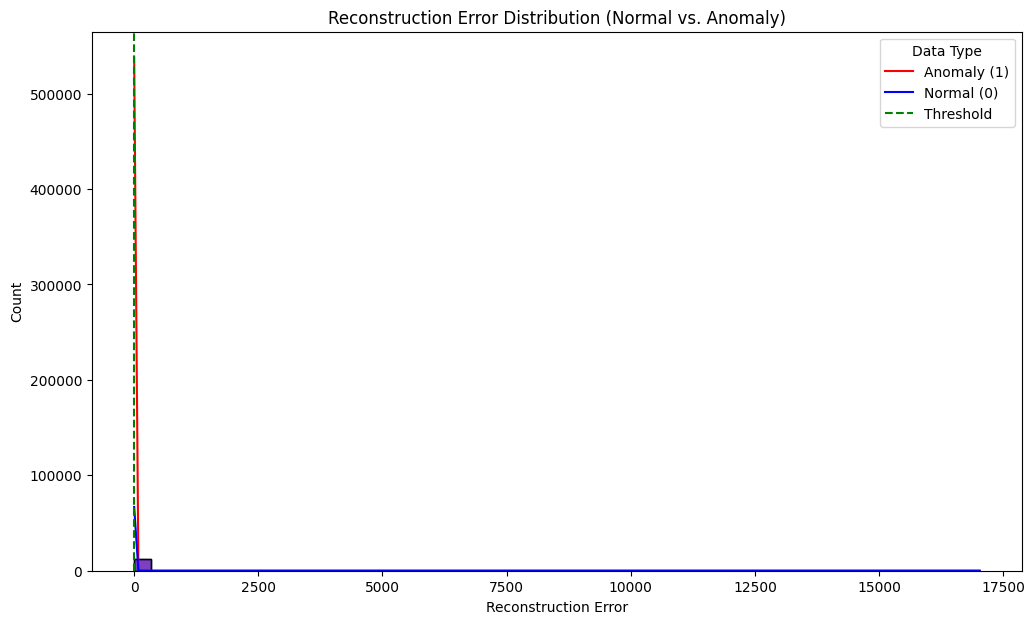

In [5]:
# ÌèâÍ∞Ä ÏΩîÎìú 2Îã®Í≥ÑÏóêÏÑú 'total_test_errors'ÏôÄ 'y_test_labels'Î•º Í≥ÑÏÇ∞Ìïú ÌõÑ Ïã§Ìñâ

error_df = pd.DataFrame({
    'error': total_test_errors,
    'label': y_test_labels
})

plt.figure(figsize=(12, 7))
sns.histplot(data=error_df, x='error', hue='label', bins=50, kde=True, palette=['blue', 'red'])
plt.axvline(x=optimal_threshold, color='green', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.title('Reconstruction Error Distribution (Normal vs. Anomaly)')
plt.xlabel('Reconstruction Error')
plt.legend(title='Data Type', labels=['Anomaly (1)', 'Normal (0)', 'Threshold'])
plt.show()

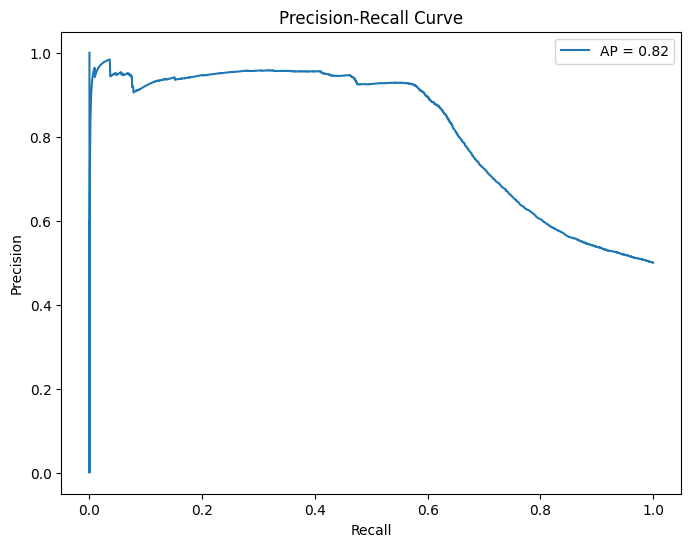

In [6]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds_pr = precision_recall_curve(y_test_labels, total_test_errors)
ap_score = average_precision_score(y_test_labels, total_test_errors)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

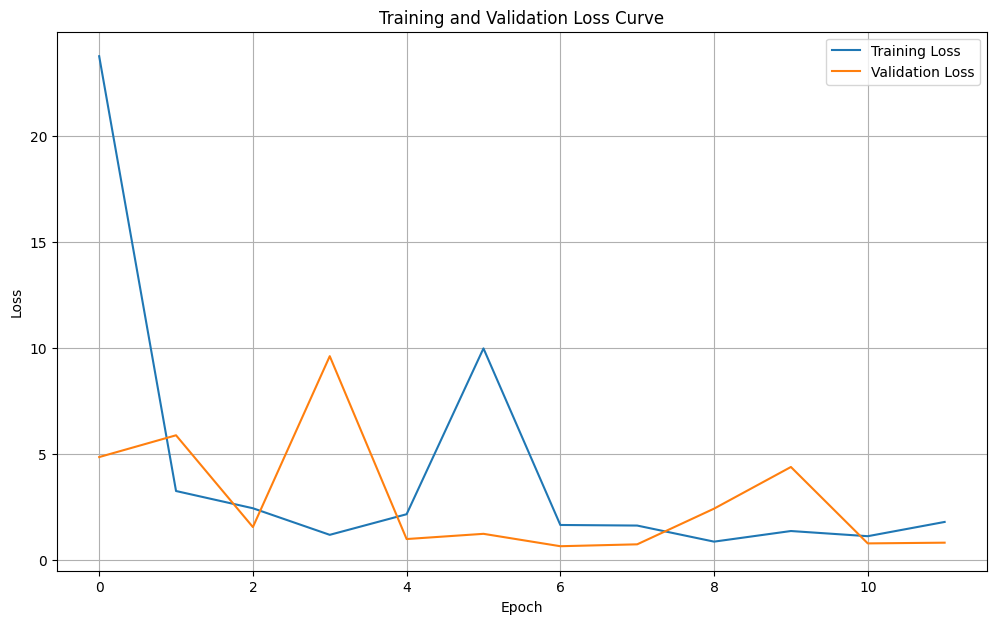

In [7]:
# model.fit()Ïù¥ ÎÅùÎÇú ÏßÅÌõÑ, 'history' Í∞ùÏ≤¥Î•º ÏÇ¨Ïö©ÌïòÏó¨ Ïã§Ìñâ
history_df = pd.DataFrame(history.history)

# Keras 3.x ÏóêÏÑúÎäî loss Ïù¥Î¶ÑÏù¥ Îã§Î•º Ïàò ÏûàÏùå (Ïòà: 'loss', 'output_location_loss' Îì±)
# history.history.keys()Î•º Ï∂úÎ†•Ìï¥ÏÑú Ï†ïÌôïÌïú ÌÇ§ Ïù¥Î¶ÑÏùÑ ÌôïÏù∏ÌïòÏÑ∏Ïöî.
# Ïó¨Í∏∞ÏÑúÎäî 'loss'ÏôÄ 'val_loss'Î•º Í∏∞Î≥∏ÏúºÎ°ú Í∞ÄÏ†ïÌï©ÎãàÎã§.

plt.figure(figsize=(12, 7))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()